### Demand Forecasting for retail chain

#### Machine Learning Project
- Understanding the Problem Statement
- Data Collection
- Data Checks to perform
- Exploratory data analysis
- Feature Engineering ( Time features, Lag features)
- Data Pre-Processing
- Data preparation
- Model Training
- Choose best model

##### 1) Problem statement
This project focuses on item-level demand forecasting. \
The primary objective is to forecast the next 14 days of sales (units sold) at a Store × Item × Day granularity, closely reflecting real-world retail demand planning systems.

##### 2) Data Collection
The dataset spans January 2024 to December 2025 and contains 50,000 transaction records, incorporating key business drivers such as promotions, holidays, pricing, footfall, and external factors like weather and temperature.

##### 2.1 Import Data and Required Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import csv data as pandas dataframe
df = pd.read_csv("data/walmart_daily_sales_2025_realistic.csv", parse_dates=['date'])

In [3]:
df.head()

,date,store_id,category,sub_category,item_id,is_weekend,is_holiday,units_sold,revenue,avg_price,footfall,promotion_discount_pct,promotion_type,holiday_type,weather_condition,temperature_c
0,2025-01-01,Store_1,Household,General,Hsh_Item_1,0,0,22.0,3293.84,187.15,344,20,Clearance,no_holiday,Storm,23.3
1,2025-01-02,Store_1,Household,General,Hsh_Item_1,0,0,25.0,3115.18,178.01,415,30,BOGO,no_holiday,Rainy,19.5
2,2025-01-03,Store_1,Household,General,Hsh_Item_1,0,0,15.0,2271.96,189.33,313,20,no_promotion,no_holiday,Storm,39.3
3,2025-01-04,Store_1,Household,General,Hsh_Item_1,1,0,16.0,2261.62,201.93,371,30,no_promotion,no_holiday,Sunny,16.2
4,2025-01-05,Store_1,Household,General,Hsh_Item_1,1,0,21.0,3709.23,176.63,369,0,no_promotion,no_holiday,Storm,26.0


In [4]:
df.shape

(11852, 16)

#### 2.2 Dataset information

Hierarchy
| Level        | Column         |
| ------------ | -------------- |
| Store        | `store_id`     |
| Category     | `category`     |
| Sub-category | `sub_category` |
| Item (SKU)   | `item_id`      |

Target
| Column       | Description                             |
| ------------ | --------------------------------------- |
| `units_sold` | Daily item-level demand (forecast this) |

Time & Events

- date
- is_weekend
- is_holiday
- holiday_type

Commercial Drivers
- promotion_type
- promotion_discount_pct
- avg_price
- footfall

External Factors

- temperature_c
- weather_condition

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11852 entries, 0 to 11851
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    11852 non-null  datetime64[ns]
 1   store_id                11852 non-null  object        
 2   category                11852 non-null  object        
 3   sub_category            11852 non-null  object        
 4   item_id                 11852 non-null  object        
 5   is_weekend              11852 non-null  int64         
 6   is_holiday              11852 non-null  int64         
 7   units_sold              11852 non-null  float64       
 8   revenue                 11852 non-null  float64       
 9   avg_price               11852 non-null  float64       
 10  footfall                11852 non-null  int64         
 11  promotion_discount_pct  11852 non-null  int64         
 12  promotion_type          11852 non-null  object

In [6]:
#Time covergence and granularity check
df['date'].min(), df['date'].max()

(Timestamp('2025-01-01 00:00:00'), Timestamp('2025-12-31 00:00:00'))

#### 3) Data checks

In [7]:
df.isna().sum()

date                      0
store_id                  0
category                  0
sub_category              0
item_id                   0
is_weekend                0
is_holiday                0
units_sold                0
revenue                   0
avg_price                 0
footfall                  0
promotion_discount_pct    0
promotion_type            0
holiday_type              0
weather_condition         0
temperature_c             0
dtype: int64

In [8]:
# check for duplicate values
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,date,is_weekend,is_holiday,units_sold,revenue,avg_price,footfall,promotion_discount_pct,temperature_c
count,11852,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000,11852.000000
mean,2025-07-01 15:47:41.289234176,0.284340,0.048346,20.328890,2818.004644,155.784349,353.260969,14.781471,27.460420
min,2025-01-01 00:00:00,0.000000,0.000000,1.000000,55.730000,55.070000,19.000000,0.000000,15.000000
25%,2025-04-01 00:00:00,0.000000,0.000000,16.000000,1987.327500,151.897500,304.750000,0.000000,21.200000
50%,2025-07-01 00:00:00,0.000000,0.000000,20.000000,2989.620000,174.420000,380.000000,10.000000,27.400000
75%,2025-10-01 00:00:00,1.000000,0.000000,24.000000,3695.250000,186.360000,422.000000,30.000000,33.800000
max,2025-12-31 00:00:00,1.000000,1.000000,57.000000,8466.350000,236.540000,590.000000,30.000000,40.000000
std,NaN,0.451119,0.214506,6.319777,1331.496749,46.050903,97.717504,11.277126,7.248264


In [10]:
# Check the store_ids

for col in ['store_id', 'category', 'sub_category', 'item_id', 'is_weekend', 'is_holiday', 'holiday_type', 'promotion_type', 'weather_condition']:
    print(col, "\n", df[col].unique(), "\n")

store_id 
 ['Store_1' 'Store_2' 'Store_3' 'Store_4' 'Store_5'] 

category 
 ['Household' 'Clothing'] 

sub_category 
 ['General' 'Kids'] 

item_id 
 ['Hsh_Item_1' 'Hsh_Item_2' 'Hsh_Item_3' 'Hsh_Item_4' 'Hsh_Item_5'
 'Clo_Kid_1' 'Clo_Kid_2' 'Clo_Kid_3' 'Clo_Kid_4' 'Clo_Kid_5'] 

is_weekend 
 [0 1] 

is_holiday 
 [0 1] 

holiday_type 
 ['no_holiday' 'Christmas' 'NewYear' 'IndependenceDay'] 

promotion_type 
 ['Clearance' 'BOGO' 'no_promotion' 'Discount'] 

weather_condition 
 ['Storm' 'Rainy' 'Sunny' 'Cloudy'] 



In [11]:
df.nunique()

date                        365
store_id                      5
category                      2
sub_category                  2
item_id                      10
is_weekend                    2
is_holiday                    2
units_sold                   51
revenue                   11489
avg_price                  6108
footfall                    488
promotion_discount_pct        4
promotion_type                4
holiday_type                  4
weather_condition             4
temperature_c               251
dtype: int64

In [12]:
# define numerical & categorical features columns
numerical_features = [col for col in df.columns if df[col].dtype != 'O']
categorical_features = [col for col in df.columns if df[col].dtype == 'O']

In [13]:
print(f"We have {len(numerical_features)} numercial features, which are {numerical_features}")
print(f"We have {len(categorical_features)} categorical features, which are {categorical_features}")

We have 9 numercial features, which are ['date', 'is_weekend', 'is_holiday', 'units_sold', 'revenue', 'avg_price', 'footfall', 'promotion_discount_pct', 'temperature_c']
We have 7 categorical features, which are ['store_id', 'category', 'sub_category', 'item_id', 'promotion_type', 'holiday_type', 'weather_condition']


#### 4) Exploring the data

In [14]:
# Ensures each SKU has enough history
df.groupby('item_id')['date'].nunique().describe()

count     10.000000
mean     335.100000
std       31.918124
min      293.000000
25%      307.500000
50%      339.000000
75%      365.000000
max      365.000000
Name: date, dtype: float64

In [15]:
# Target varaible analysis - unit sold

In [16]:
# Distribution of daily sales
df['units_sold'].describe()

count    11852.000000
mean        20.328890
std          6.319777
min          1.000000
25%         16.000000
50%         20.000000
75%         24.000000
max         57.000000
Name: units_sold, dtype: float64

<Axes: >

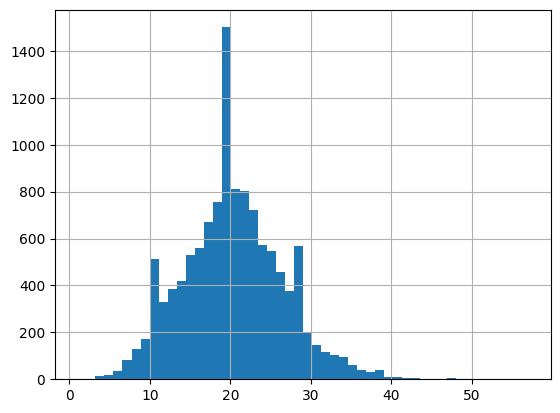

In [17]:
df['units_sold'].hist(bins=50)

In [18]:
# Right skewed distribution
# Presence of low and high-selling SKUs

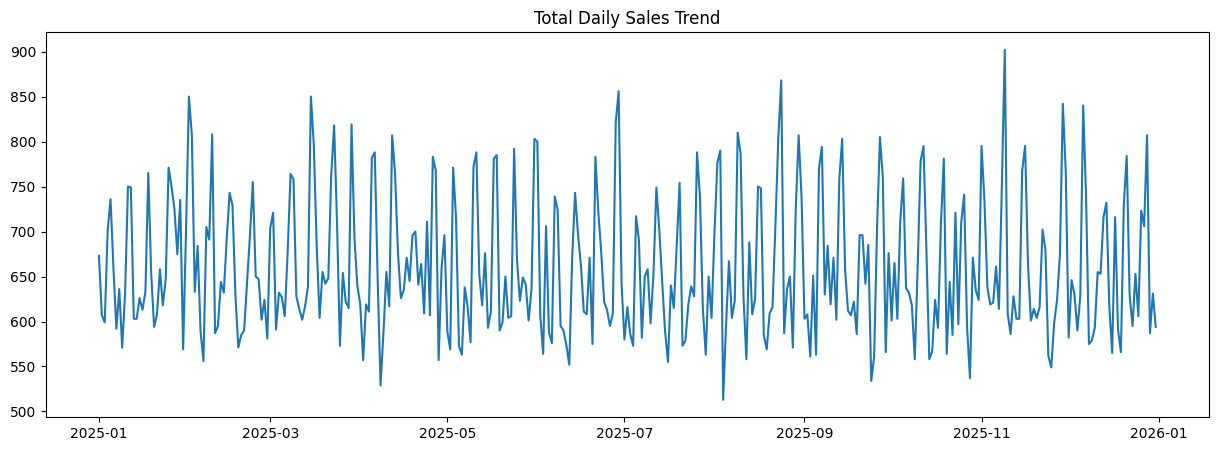

In [19]:
#Sales trend over time
daily_sales = df.groupby('date')['units_sold'].sum()
plt.figure(figsize=(15,5))
plt.plot(daily_sales)
plt.title("Total Daily Sales Trend")
plt.show()

In [20]:
# Can identify seasonal spikes

In [21]:
# Seaonlity Analysis

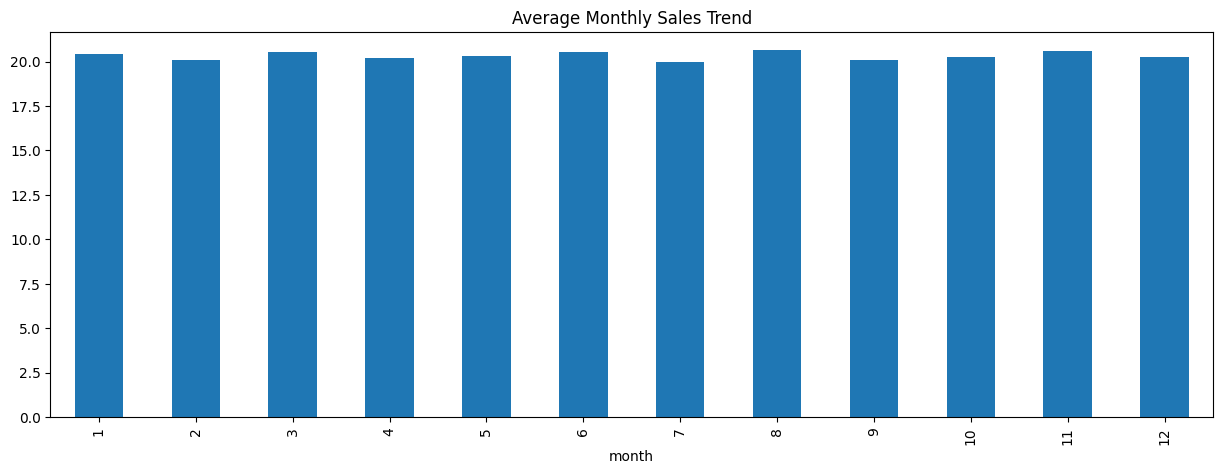

In [22]:
# Monhtly Seasonlaity'
df['month'] = df['date'].dt.month
monthly_sales = df.groupby('month')['units_sold'].mean()
plt.figure(figsize=(15,5))
monthly_sales.plot(kind='bar')
plt.title("Average Monthly Sales Trend")
plt.show()


In [23]:
# Not seen monthly sales variations

In [24]:
# Weekend vs Weekday Impact
df.groupby('is_weekend')['units_sold'].mean()

is_weekend
0    19.086890
1    23.454896
Name: units_sold, dtype: float64

In [25]:
# Weekend shows higher average demand

In [26]:
# Holiday impact analysis
df.groupby('is_holiday')['units_sold'].mean()

is_holiday
0    19.997340
1    26.855148
Name: units_sold, dtype: float64

In [27]:
df.groupby("holiday_type")["units_sold"].mean().sort_values(ascending=False)


holiday_type
NewYear            27.205479
IndependenceDay    26.834483
Christmas          26.070866
no_holiday         20.094805
Name: units_sold, dtype: float64

In [28]:
# Holiday significantly boost demand

In [29]:
# Promotion Effectiveness
df.groupby('promotion_type')['units_sold'].mean()

promotion_type
BOGO            20.902527
Clearance       20.915285
Discount        20.899729
no_promotion    19.603429
Name: units_sold, dtype: float64

In [30]:
df.groupby('promotion_type')['units_sold'].median()

promotion_type
BOGO            21.0
Clearance       21.0
Discount        21.0
no_promotion    19.0
Name: units_sold, dtype: float64

In [31]:
# Promotion increased demands
# Discount and BOGO outperform discount

In [32]:
# Price vs Demand Relationship
df[['avg_price','units_sold']].corr()

,avg_price,units_sold
avg_price,1.000000,0.555257
units_sold,0.555257,1.000000


<Axes: xlabel='avg_price', ylabel='units_sold'>

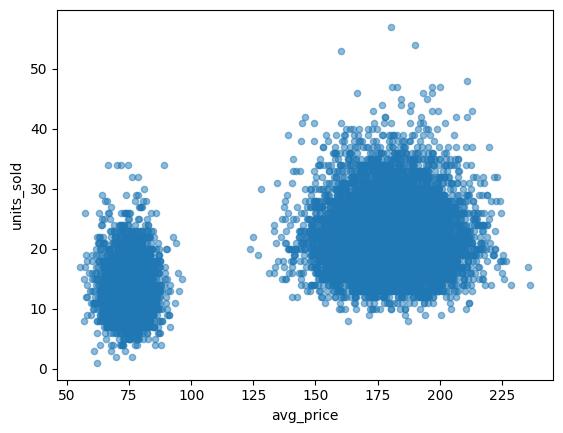

In [33]:
df.plot.scatter(x='avg_price', y='units_sold', alpha=0.5)

In [34]:
# Weak relationship
# confirms non-linear relationship

In [35]:
# Category & Item-Level Analysis
df.groupby('category')['units_sold'].mean().sort_values()

category
Clothing     13.624129
Household    22.332603
Name: units_sold, dtype: float64

In [36]:
top_items = (
    df.groupby('category')['units_sold']
    .sum()
    .sort_values(ascending=False)
)
top_items

category
Household    203785.0
Clothing      37153.0
Name: units_sold, dtype: float64

In [37]:
# According to this identifies ast vs slow movers
# It may useful for ABC classification & differentiated forecasting stragtegies

In [38]:
# External factor impact
# Weather condition
df.groupby("weather_condition")["units_sold"].mean()

weather_condition
Cloudy    20.410120
Rainy     20.201605
Storm     20.346707
Sunny     20.357990
Name: units_sold, dtype: float64

In [39]:
# Footfall
df[['footfall','units_sold']].corr()

,footfall,units_sold
footfall,1.000000,0.734729
units_sold,0.734729,1.000000


<Axes: xlabel='footfall', ylabel='units_sold'>

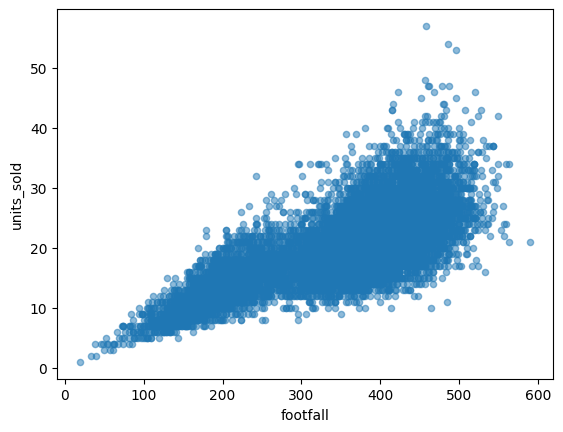

In [40]:
df.plot.scatter(x='footfall', y='units_sold', alpha=0.5)

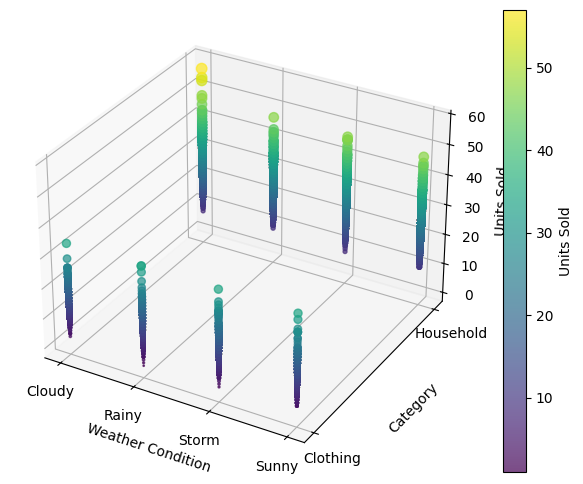

In [41]:
df_wa = df

# Encode categorical variables
df_wa["Weather_Code"] = df_wa["weather_condition"].astype("category").cat.codes
df_wa["Category_Code"] = df_wa["category"].astype("category").cat.codes

# Create 3D scatterplot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Use Units_Sold for both color (hue) and size
scatter = ax.scatter(
    df_wa["Weather_Code"], 
    df_wa["Category_Code"], 
    df_wa["units_sold"],
    c=df_wa["units_sold"],          # color intensity
    s=df_wa["units_sold"],          # marker size (bigger = more sales)
    cmap="viridis", 
    alpha=0.7
)

ax.set_xlabel("Weather Condition")
ax.set_ylabel("Category")
ax.set_zlabel("Units Sold")

# Restore tick labels to original categories
ax.set_xticks(df_wa["Weather_Code"].unique())
ax.set_xticklabels(df_wa["weather_condition"].unique())

ax.set_yticks(df_wa["Category_Code"].unique())
ax.set_yticklabels(df_wa["category"].unique())

# Add colorbar to show sales scale
fig.colorbar(scatter, ax=ax, label="Units Sold")

plt.show()


In [42]:
df = df.drop(columns=['Weather_Code', 'Category_Code'], axis=1)
df.columns

Index(['date', 'store_id', 'category', 'sub_category', 'item_id', 'is_weekend',
       'is_holiday', 'units_sold', 'revenue', 'avg_price', 'footfall',
       'promotion_discount_pct', 'promotion_type', 'holiday_type',
       'weather_condition', 'temperature_c', 'month'],
      dtype='object')

Bivariate Analysis

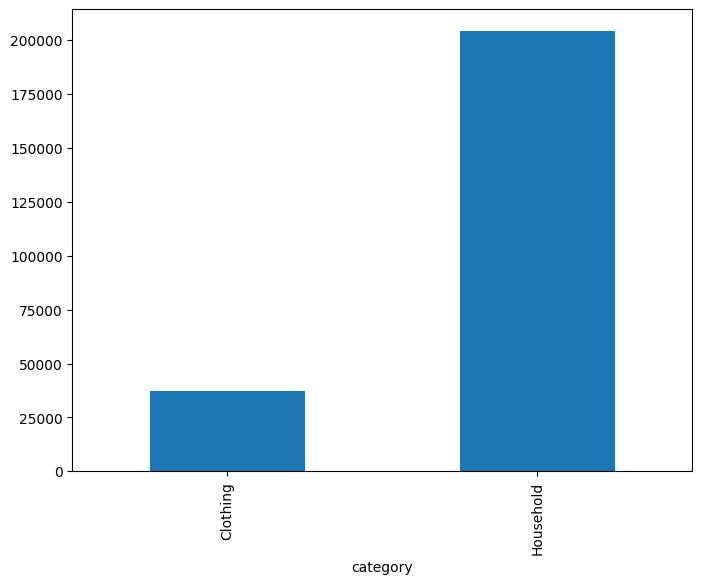

In [43]:
# category_sales
category_sales = df.groupby('category')['units_sold'].sum()

plt.figure(figsize=(8,6))
category_sales.plot(kind='bar')
plt.show()

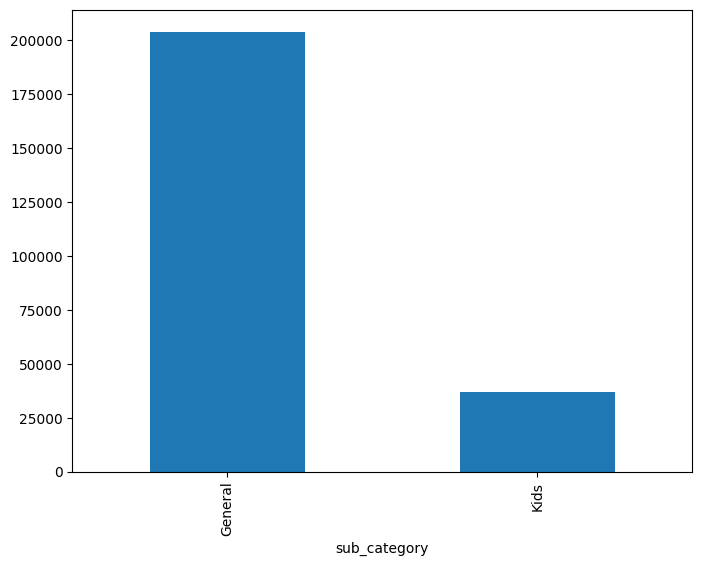

In [44]:
# category_sales
sub_category_sales = df.groupby('sub_category')['units_sold'].sum()

plt.figure(figsize=(8,6))
sub_category_sales.plot(kind='bar')
plt.show()

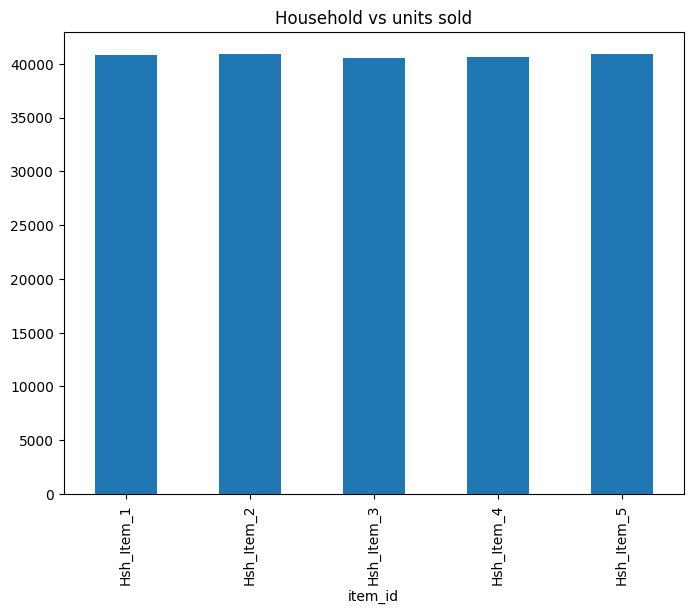

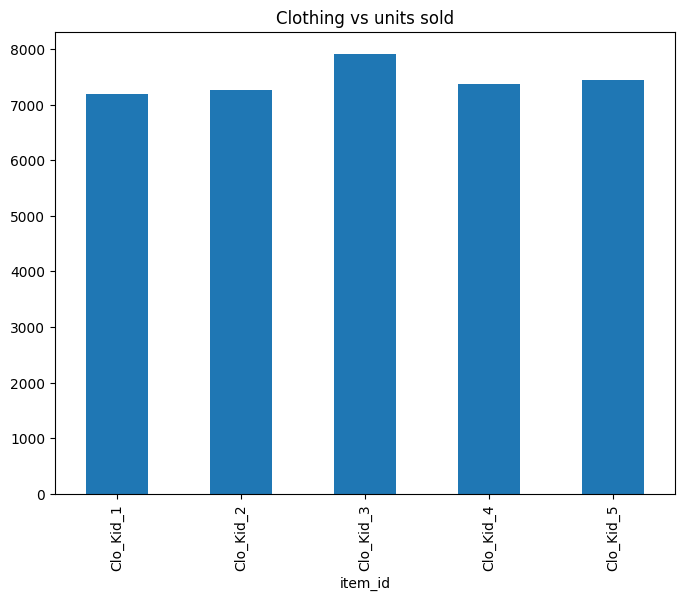

In [45]:
# item_sales

for cat in df['category'].unique():
    item_sales = df[df['category']==cat].groupby('item_id')['units_sold'].sum()
    
    plt.figure(figsize=(8,6))
    plt.title(f"{cat} vs units sold")
    item_sales.plot(kind='bar')
    plt.show()



In [46]:
for cat in df['category'].unique():
    print(cat)

Household
Clothing


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11852 entries, 0 to 11851
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    11852 non-null  datetime64[ns]
 1   store_id                11852 non-null  object        
 2   category                11852 non-null  object        
 3   sub_category            11852 non-null  object        
 4   item_id                 11852 non-null  object        
 5   is_weekend              11852 non-null  int64         
 6   is_holiday              11852 non-null  int64         
 7   units_sold              11852 non-null  float64       
 8   revenue                 11852 non-null  float64       
 9   avg_price               11852 non-null  float64       
 10  footfall                11852 non-null  int64         
 11  promotion_discount_pct  11852 non-null  int64         
 12  promotion_type          11852 non-null  object

6) Data Preprocessing

In [48]:
daily_df = (
    df.groupby(["store_id", "item_id", "date"], as_index=False)
    .agg({
          "units_sold": "sum",   # critical
          "revenue": "max",
          "avg_price": "mean",
          "footfall": "mean",
          "promotion_discount_pct": "mean",
          "is_holiday": "max",
          "category": "first",
          "sub_category": "first",
          "is_weekend": "first",
          "promotion_type": "first",
          "holiday_type": "first",
          "weather_condition": "first",
          "temperature_c": "first",
          "month": "first"
      })
)

In [49]:
all_dates = pd.date_range(
    start=daily_df['date'].min(),
    end=daily_df['date'].max(),
    freq='D'
)

stores = daily_df['store_id'].unique()
items = daily_df['item_id'].unique()

full_index = pd.MultiIndex.from_product(
    [all_dates, stores, items],
    names=['date', 'store_id', 'item_id']
)

In [50]:
daily_df.isnull().sum()

store_id                  0
item_id                   0
date                      0
units_sold                0
revenue                   0
avg_price                 0
footfall                  0
promotion_discount_pct    0
is_holiday                0
category                  0
sub_category              0
is_weekend                0
promotion_type            0
holiday_type              0
weather_condition         0
temperature_c             0
month                     0
dtype: int64

In [51]:
df_full = (
    df
    .set_index(['date', 'store_id', 'item_id'])
    .reindex(full_index)
    .reset_index()
)


In [52]:
df_full.head()

,date,store_id,item_id,category,sub_category,is_weekend,is_holiday,units_sold,revenue,avg_price,footfall,promotion_discount_pct,promotion_type,holiday_type,weather_condition,temperature_c,month
0,2025-01-01,Store_1,Clo_Kid_1,Clothing,Kids,0.0,0.0,15.0,815.32,77.65,224.0,30.0,no_promotion,no_holiday,Storm,22.3,1.0
1,2025-01-01,Store_1,Clo_Kid_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-01,Store_1,Clo_Kid_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-01,Store_1,Clo_Kid_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-01,Store_1,Clo_Kid_5,Clothing,Kids,0.0,0.0,19.0,1025.85,67.49,235.0,20.0,Discount,no_holiday,Storm,20.9,1.0


In [53]:
len(df_full)

18250

##### Insights
- The distribution of target variable (units sold) is right skewed. 
- Can identify seasonal spikes, but not seemed as monthly variations.
- The number of units sold is higher in weekends than the weekdays.
- Hoildays boosting demand specially Easter holidays.
- Promotions boosing demanding demand specially Clearance.
- There's no linear correlation observed between average price and units sold.
- Among categories 'Houshold'showing a higher demand among 5 categories.
- footfall showing positive correlation with sales
- Weather conditions not seeming to be affecting the unitsold as we see same distributio for each weather condition. 
- Sales getting heigher when months starts as well as month ends.


#### Data Preparation

Convert transactional data into a dense daily time series per store–item

In [ ]:
# Reindexing Function to handle missing dates
def clean_and_reindex(group):
    group = group.set_index('date')
    full_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='D')
    group = group.reindex(full_range)
    
    # Impute missing values
    group['units_sold'] = group['units_sold'].fillna(0)
    group['revenue'] = group['revenue'].fillna(0)
    group['promotion_discount_pct'] = group['promotion_discount_pct'].fillna(0)
    group['promotion_type'] = group['promotion_type'].fillna('no_promotion')
    group['avg_price'] = group['avg_price'].ffill().bfill() # Carry price forward
    group['store_id'] = group['store_id'].ffill().bfill()
    group['category'] = group['category'].ffill().bfill()
    group['sub_category'] = group['sub_category'].ffill().bfill()
    group['footfall'] = group['footfall'].ffill().bfill()
    group['item_id'] = group['item_id'].ffill().bfill()
    return group.reset_index().rename(columns={'index': 'date'})

In [ ]:
df_calendar = df_full.groupby("date", as_index=False).agg({
    'is_weekend': "first",
    'is_holiday': "first",
    'holiday_type': "first",
    'weather_condition': "first", 
    'temperature_c': "first", 
    'month': "first"
})

In [56]:
df_filled = df_full.groupby(['store_id', 'item_id'], group_keys=False).apply(clean_and_reindex)

df_filled = df_filled.drop(columns=['is_weekend', 'is_holiday', 'holiday_type','weather_condition', 'temperature_c', 'month'], axis=1)

df_filled = df_filled.merge(
    df_calendar,
    on = 'date',
    how = 'left')

In [57]:
# Create timeseries feature engineering

df_filled['day_of_week'] = df_filled["date"].dt.dayofweek
df_filled['week_of_year'] = df_filled["date"].dt.isocalendar().week.astype(int)
df_filled['is_month_start'] = df_filled['date'].dt.is_month_start.astype(int)
df_filled['is_month_end'] = df_filled['date'].dt.is_month_end.astype(int)

In [58]:
# Sort & Group
df_filled = df_filled.sort_values(
    ['store_id', 'item_id', 'date']
).reset_index(drop=True)

In [ ]:
# Lag Features

# Short-term memory → lag_1, lag_3
# Weekly seasonality → lag_7
# Monthly trend → lag_14, lag_28

LAGS = [1, 3, 7, 14, 28]

for lag in LAGS:
    df_filled[f'units_sold_lag_{lag}'] = (
        df_filled
        .groupby(['store_id', 'item_id'])['units_sold']
        .shift(lag)
    )

In [ ]:
# Rolling Window Statistics for stability and trend

# Rolling means
WINDOWS = [7, 14, 28]

for w in WINDOWS:
    df_filled[f'rolling_mean_{w}'] = (
        df_filled
        .groupby(['store_id', 'item_id'])['units_sold']
        .shift(1)
        .rolling(w)
        .mean()
    )

In [61]:
# Rolling volatility
for w in WINDOWS:
    df_filled[f'rolling_std_{w}'] = (
        df_filled
        .groupby(['store_id', 'item_id'])['units_sold']
        .shift(1)
        .rolling(w)
        .std()
    )

In [62]:
# Rolling max (captures spikes)
df_filled['rolling_max_7'] = (
    df_filled
    .groupby(['store_id', 'item_id'])['units_sold']
    .shift(1)
    .rolling(7)
    .max()
)

In [63]:
# Intermittent Demand Features

# Zero-sales flag
df_filled['zero_sales_flag'] = (df_filled['units_sold'] == 0).astype(int)

In [64]:
# Price & Promotion Dynamics
df_filled['price_lag_7'] = (
    df_filled
    .groupby(['store_id', 'item_id'])['avg_price']
    .shift(7)
)

In [65]:
# Relative price change
df_filled['price_change_pct_7'] = (
    (df_filled['avg_price'] - df_filled['price_lag_7'])
    / df_filled['price_lag_7']
)

In [66]:
# Promotion frequency (last 7 days)
df_filled['promo_flag'] = (
    df_filled['promotion_discount_pct'] > 0
).astype(int)

df_filled['promo_days_last_7'] = (
    df_filled
    .groupby(['store_id', 'item_id'])['promo_flag']
    .shift(1)
    .rolling(7)
    .sum()
)

In [67]:
# Calendar Cyclic Encoding

# Day of week
df_filled['dow_sin'] = np.sin(2 * np.pi * df_filled['day_of_week'] / 7)
df_filled['dow_cos'] = np.cos(2 * np.pi * df_filled['day_of_week'] / 7)

# Month
df_filled['month_sin'] = np.sin(2 * np.pi * df_filled['month'] / 12)
df_filled['month_cos'] = np.cos(2 * np.pi * df_filled['month'] / 12)

In [68]:
# Create 7-Day Forecast Targets (Multi-Horizon)
for h in range(1, 8):
    df_filled[f'y_t_plus_{h}'] = (
        df_filled
        .groupby(['store_id', 'item_id'])['units_sold']
        .shift(-h)
    )

In [69]:
df_filled.head()

,date,store_id,item_id,category,sub_category,units_sold,revenue,avg_price,footfall,promotion_discount_pct,...,dow_cos,month_sin,month_cos,y_t_plus_1,y_t_plus_2,y_t_plus_3,y_t_plus_4,y_t_plus_5,y_t_plus_6,y_t_plus_7
0,2025-01-01,Store_1,Clo_Kid_1,Clothing,Kids,15.0,815.32,77.65,224.0,30.0,...,-0.222521,0.5,0.866025,0.0,17.0,0.0,0.0,0.0,0.0,0.0
1,2025-01-02,Store_1,Clo_Kid_1,Clothing,Kids,0.0,0.00,77.65,224.0,0.0,...,-0.900969,0.5,0.866025,17.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-01-03,Store_1,Clo_Kid_1,Clothing,Kids,17.0,1047.44,68.46,227.0,10.0,...,-0.900969,0.5,0.866025,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-01-04,Store_1,Clo_Kid_1,Clothing,Kids,0.0,0.00,68.46,227.0,0.0,...,-0.222521,0.5,0.866025,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-01-05,Store_1,Clo_Kid_1,Clothing,Kids,0.0,0.00,68.46,227.0,0.0,...,0.623490,0.5,0.866025,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
len(df_filled)

18250

In [71]:
df_model = df_filled.dropna().reset_index(drop=True)

In [72]:
len(df_model)

16500

In [73]:
df_model['date'].nunique()

330

In [74]:
print(df_model.shape)
df_model[['units_sold', 'units_sold_lag_7', 'rolling_mean_7']].head(10)

(16500, 49)


,units_sold,units_sold_lag_7,rolling_mean_7
0,16.0,0.0,8.428571
1,0.0,0.0,10.714286
2,0.0,14.0,10.714286
3,0.0,17.0,8.714286
4,0.0,0.0,6.285714
5,0.0,14.0,6.285714
6,19.0,14.0,4.285714
7,13.0,16.0,5.000000
8,0.0,0.0,4.571429
9,0.0,0.0,4.571429


In [76]:
df_model.to_csv('data/df_model.csv', index=False)